# Estimating the k-mer density in the E. coli genome

In this notebook we are using SeqDEFT and to infer the k-mer density of the E.coli genome and the visualization technique to illustrate which sequence properties either increase the changes of being more represented in the genome and which are depleted

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import gpmap.src.plot as plot
import gpmap.src.inference as inf

from gpmap.src.space import SequenceSpace
from gpmap.src.randwalk import WMWSWalk

from scipy.special._logsumexp import logsumexp
from scipy.stats.stats import pearsonr

# Load k-mer counts

k-mer counts have been previously calculated using Jellyfish directly on the genome fasta file downloaded from Ensembl. We are directly loading those counts to apply SeqDEFT

In [2]:
k = 9
exp_kmers = 4**k
data = pd.read_csv('e_coli.{}mer.counts.tsv'.format(k), sep='\t', index_col=0, header=None)
data.columns = ['counts']

print('Total counts: {}'.format(data['counts'].sum()))
print('Number of observed {}-mers: {} out of {}'.format(k, data.shape[0], exp_kmers))
print('Missing {}-mers: {}'.format(k, exp_kmers - data.shape[0]))
print('Max number of times a {}-mer was observed: {}'.format(k, data['counts'].max()))

Total counts: 5581078
Number of observed 9-mers: 258556 out of 262144
Missing 9-mers: 3588
Max number of times a 9-mer was observed: 316


We can see that there is a significant amount of k-mers that is missing from the genome, while others are very highly represented. We can view this in more detail by just plotting the empirical distribution of counts

[Text(0.5, 0, 'k-mer counts'), Text(0, 0.5, '# of k-mers')]

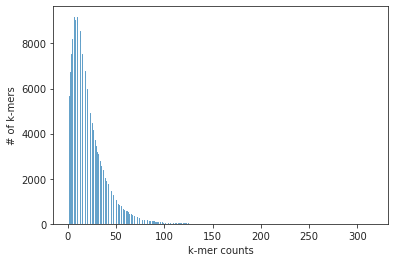

In [3]:
fig, axes = plot.init_fig(1, 1, figsize=(6, 4))

sns.histplot(data['counts'], ax=axes)
axes.set(xlabel='k-mer counts', ylabel='# of k-mers')

# Run SeqDEFT inference

In [4]:
seqdeft = inf.SeqDEFT(P=3)
inf_densities = seqdeft.fit(X=data.index.values, counts=data['counts'].values)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [55:56<00:00, 33.57s/it]


In [6]:
data = data.join(inf_densities)
data.head()

,counts,frequency,Q_star
0,,,
AAAAAAAAA,14,0.000003,0.000007
AAAAAAAAC,45,0.000008,0.000010
AAAAAAAAG,47,0.000008,0.000010
AAAAAAAAT,60,0.000011,0.000012
AAAAAAACA,73,0.000013,0.000013


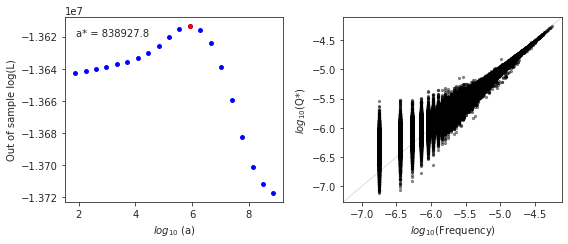

In [7]:
fig = plot.plot_SeqDEFT_summary(seqdeft.log_Ls, inf_densities)

[Text(0.5, 0, 'k-mer $\\log_{10}(Q*)$'), Text(0, 0.5, '# of k-mers')]

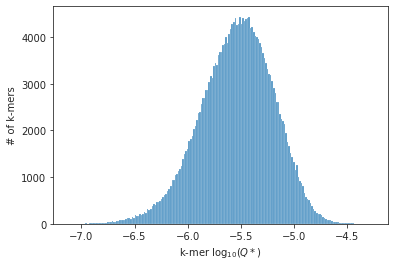

In [40]:
fig, axes = plot.init_fig(1, 1, figsize=(6, 4))

sns.histplot(np.log10(data['Q_star']), ax=axes)
axes.set(xlabel=r'k-mer $\log_{10}(Q*)$', ylabel='# of k-mers')

# Visualizing the inferred landscape

In [29]:
space = SequenceSpace(seq_length=9, alphabet_type='dna', 
                      function=np.log10(inf_densities['Q_star']))
rw = WMWSWalk(space)

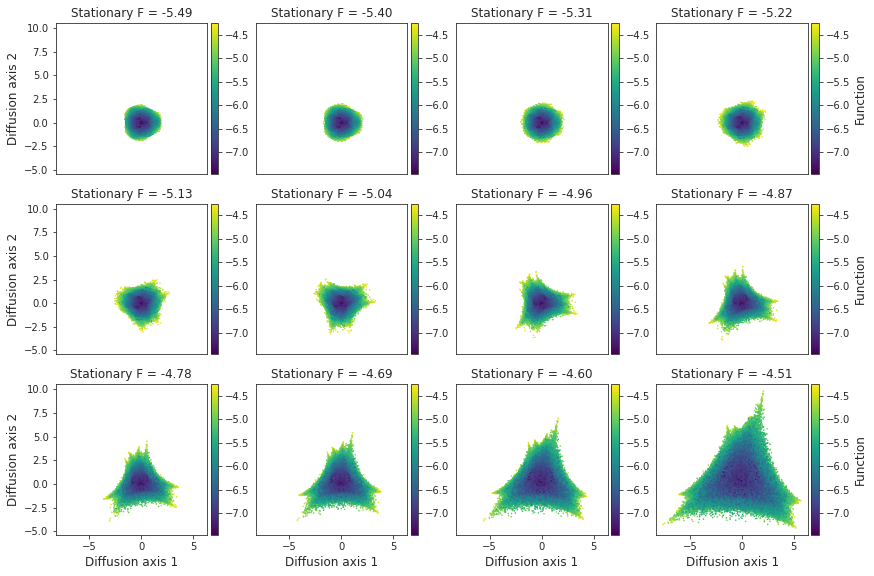

In [34]:
plot.figure_Ns_grid(rw, show_edges=False)

In [35]:
rw.calc_visualization(mean_function=-4.5)
nodes_df, edges_df = rw.nodes_df, rw.space.get_edges_df()
decay_df = rw.decay_rates_df
decay_df

,k,decay_rates,relaxation_time
0,1,0.045429,22.012292
1,2,0.047027,21.264457
2,3,0.079822,12.527824
3,4,0.086719,11.531489
4,5,0.090735,11.021165
5,6,0.117125,8.537917
6,7,0.123495,8.097468
7,8,0.151359,6.606831
8,9,0.162373,6.158667


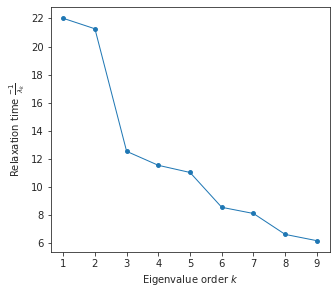

In [36]:
fig, axes = plot.init_fig(1, 1, colsize=5, rowsize=4.5)
plot.plot_relaxation_times(rw.decay_rates_df, axes)

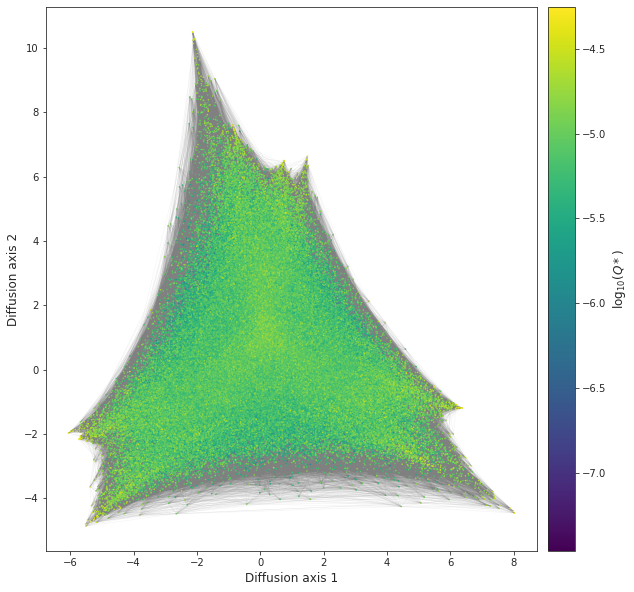

In [37]:
fig, axes = plot.init_fig(1, 1, colsize=10, rowsize=10)
plot.plot_visualization(axes, nodes_df, edges_df=edges_df,
                        ascending=True, nodes_cmap_label=r'$\log_{10}(Q*)$')

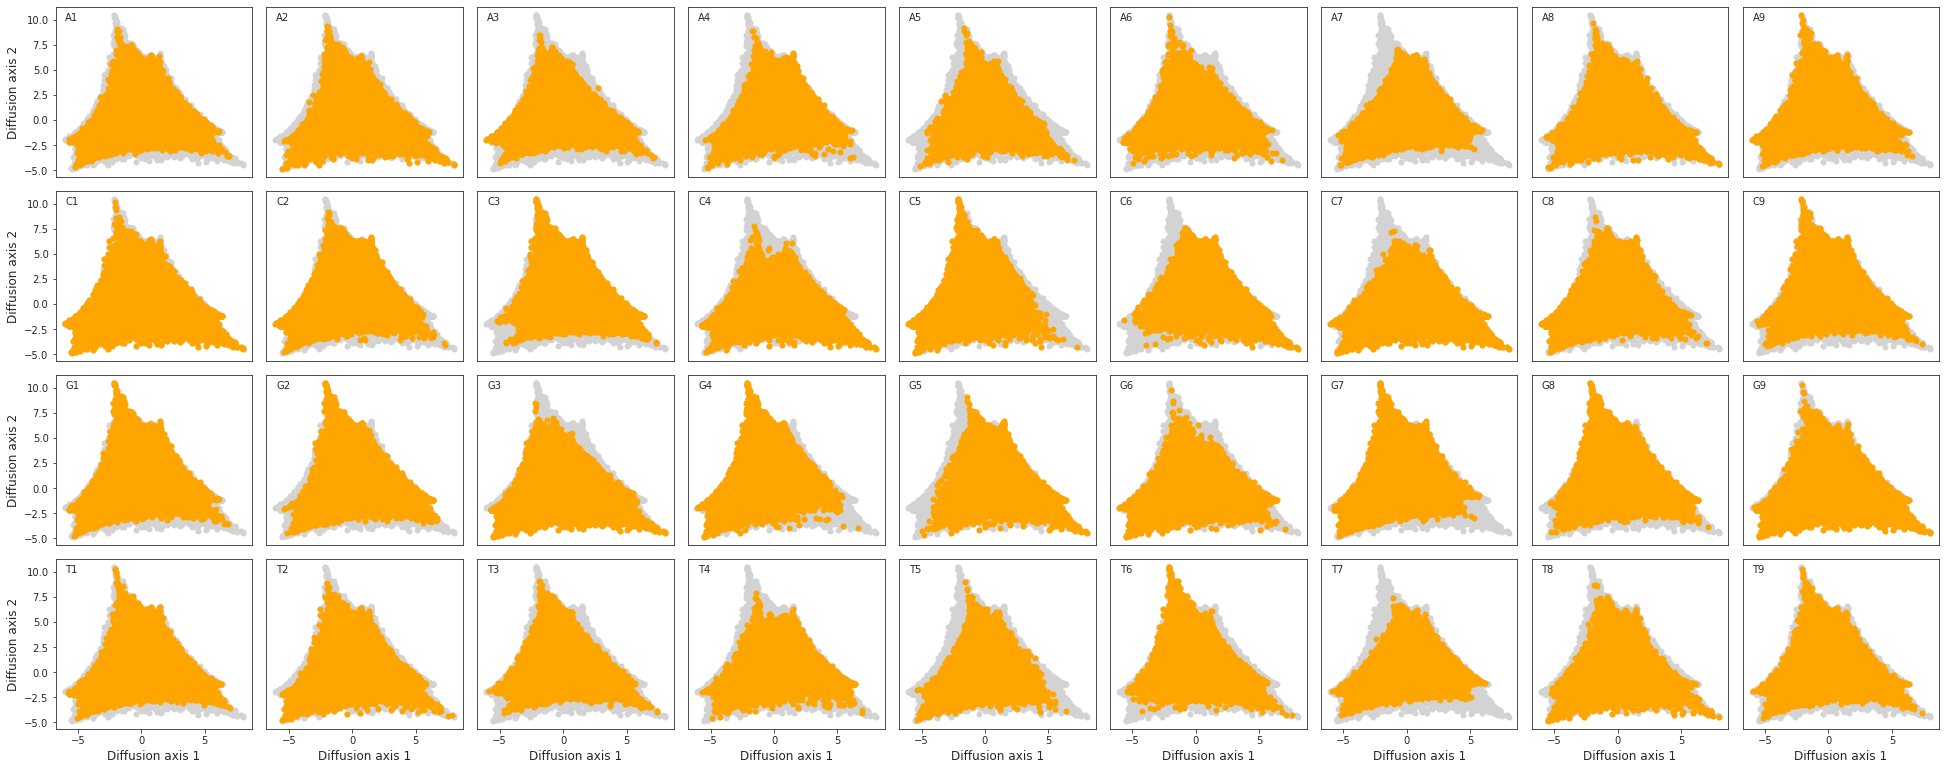

In [38]:
plot.figure_allele_grid(nodes_df, #edges_df=edges_df,
                        autoscale_axis=False)